# 15 Streamfunction and Complex Potential

In [8]:
%load_ext pymatbridge

C:\Anaconda3\lib\site-packages\IPython\nbformat.py:13: ShimWarning: The `IPython.nbformat` package has been deprecated. You should import from nbformat instead.
  "You should import from nbformat instead.", ShimWarning)


Starting MATLAB on ZMQ socket tcp://127.0.0.1:23626
Send 'exit' command to kill the server
......MATLAB started and connected!


## 15.1 Streamfunction

In [ ]:
# %load ch15/gw_flow.m
function gw_flow
% groundwater flow 
%    using MATLAB analytical solutions                   
%
%   $Ekkehard Holzbecher  $Date: 2007/02/03 $
%--------------------------------------------------------------------------
% Baseflow
H = 6.;             % thickness [L]
h0 = 5.5;           % reference piezometric head [L] 
K = 5.e-5;          % hydraulic conductivity [L/T] 
por = 0.25;         % porosity []
Qx0 = 1.e-6;        % baseflow in x-direction [L^2/T]
Qy0 = 0;            % baseflow in y-direction [L^2/T]

% Wells
x0 = [99 145];      % x-coordinates well position [L]
y0 = [50 78];       % y-coordinates well position [L]
Q = [1.e-4 1.e-4];  % pumping / recharge rates [L^3/T]
R = [0.3 0.2];      % well radius [L]

% Mesh
xmin = 0;           % minimum x-position of mesh [L]
xmax = 200;         % maximum x-position of mesh [L]
ymin = 0;           % minimum y-position of mesh [L]
ymax = 200;         % maximum y-position of mesh [L]

% Reference point position in mesh
iref = 1; jref = 1;

% Graphical output options
gsurfh = 0;         % piezometric head surface plot
gcontf = 10;        % no. filled contour lines (=0: none)
gquiv = 0;          % arrow field plot
gflowp_fit = 10;    % flowpaths forward in time
gflowp_bit = 0;     % no. flowpaths backward in time (=0: none)
gflowp_dot = 5;     % flowpaths with dots indicating speed
gstream = 10;       % streamfunction plot

%----------------------------------------execution-------------------------------
xvec = linspace(xmin,xmax,100);
yvec = linspace(ymin,ymax,100);
[x,y] = meshgrid (xvec,yvec);                      % mesh
phi = -Qx0*x - Qy0*y;                              % baseflow potential
for j = 1:size(Q,2)
    r = sqrt((x-x0(j)).*(x-x0(j))+(y-y0(j)).*(y-y0(j)));   % distances to well
    phi = phi + (Q(j)/(2*pi))*log(r);              % potential
end
if h0 > H
    phi0 = -phi(iref,jref) + K*H*h0 - 0.5*K*H*H; 
else
    phi0 = -phi(iref,jref) + 0.5*K*h0*h0;          % reference potential 
end                                                
hc = 0.5*H+(1/K/H)*(phi+phi0);                     % head confined
hu = sqrt ((2/K)*(phi+phi0));                      % head unconfined
phicrit = phi0 + 0.5*K*H*H;                        % transition confined / unconfined
confined = (phi>=phicrit);                         % confined / unconfined indicator
h = confined.*hc+~confined.*hu;                    % head
psi = -Qx0*y + Qy0*x;
for j = 1:size(Q,2)
    psi = psi + (Q(j)/(pi+pi))*atan2((y-y0(j)),(x-x0(j)));  % streamfunction 
end
%---------------------------------------display messages-------------------
if all(all(confined))
    display ('aquifer confined');
else
    if all(all(~confined)) 
        display ('aquifer unconfined'); 
    else
        display ('aquifer partially confined and unconfined'); 
    end
end    
if any(any(h<0)) 
    display ('aquifer falls partially dry'); 
    h = max(0, h);
end

%--------------------------------------------------------------------------
[u,v] = gradient (-phi);                           % discharge vector  
Hh = confined.*H + ~confined.*h;                   % aquifer depth  
u = u./Hh/(xvec(2)-xvec(1))/por; v = v./Hh/(yvec(2)-yvec(1))/por;

%--------------------------------------graphical output--------------------
if gsurfh 
    figure; surf (x,y,h);                          % surface 
end 
if gcontf || gquiv || gflowp_fit || gflow_bit || gflowp_dot || gstream figure; end
if gcontf                                          % filled contours  
    colormap(winter); 
    contourf (x,y,h,gcontf,'w'); 
    colorbar; hold on;
end
if gquiv 
    quiver (x,y,u,v,'y'); hold on;                 % arrow field
end
if gflowp_fit                                      % flowpaths 
    xstart = []; ystart = [];
    for i = 1:100
        if v(1,i) > 0 xstart = [xstart xvec(i)];...
                ystart = [ystart yvec(1)]; end
        if v(100,i) < 0 xstart = [xstart xvec(i)];...
                ystart = [ystart yvec(100)]; end
        if u(i,1) > 0 xstart = [xstart xvec(1)];...
                ystart = [ystart yvec(i)]; end
        if u(i,100) < 0 xstart = [xstart xvec(100)];...
                ystart = [ystart yvec(i)]; end
    end
    h = streamline (x,y,u,v,xstart,ystart);
    set (h,'Color','r'); 
end
if gflowp_bit          
    for j=1,size(Q,2)
        if Q(j)>0           % only for pumping wells
            xstart = x0(j) + R(j)*cos(2*pi*[1:1:gflowp_bit]/gflowp_bit); 
            ystart = y0(j) + R(j)*sin(2*pi*[1:1:gflowp_bit]/gflowp_bit);
            h = streamline (x,y,-u,-v,xstart,ystart);
            set (h,'Color','y')
        end
    end
end
if gflowp_dot
    [verts ~] = streamslice(x,y,u,v,gflowp_dot);
    sc = 10/mean(mean(sqrt(u.*u+v.*v)));
    iverts = interpstreamspeed(x,y,u,v,verts,sc);  
    h = streamline(iverts);
    set (h,'Marker','.','Color','y','MarkerSize',18)
end
if gstream
    contour (x,y,psi,gstream,'k','LineWidth',1);  
end


## 15.2 The Principle of Superposition

In [ ]:
# %load ch15/cplxPot.m
function cplxPot
% complex potential flow 
%    using MATLAB analytical solutions                   
%
%   $Ekkehard Holzbecher  $Date: 2006/05/31 $
%--------------------------------------------------------------------------
% Baseflow
H = 10;             % thickness [L]
h0 = 5;             % reference piezometric head [L] 
K = 5.e-5;          % hydraulic conductivity [L/T] 
Qx0 = 0;            % baseflow in x-direction [L^2/T]
Qy0 = 0;            % baseflow in y-direction [L^2/T]

% Wells
xwell = [150 250];          % x-coordinates well position [L]
ywell = [0 0];              % y-coordinates well position [L]
Qwell = 1.e-4*[1 -1];       % pumping / recharge rates [L^3/T]
R = [1 1];                  % well radius [L]

% Mesh
xmin = 0;           % minimum x-position of mesh [L]
xmax = 400;         % maximum x-position of mesh [L]
ymin = -100;        % minimum y-position of mesh [L]
ymax = 100;         % maximum y-position of mesh [L]

% Reference point position in mesh
iref = 1; jref = 1;

% Graphical output options
gsurfh = 0;         % piezometric head surface plot
gcontf = 16;        % no. filled contour lines (=0: none)
gquiv = 0;          % arrow field plot
gflowp_fit = 0;     % flowpaths forward in time
gflowp_bit = 0;     % no. flowpaths backward in time (=0: none)
gflowp_dot = 1;     % flowpaths with dots indicating speed
gstream = 10;       % streamfunction plot

%----------------------------------------execution-------------------------------
xvec = linspace(xmin,xmax,50);
yvec = linspace(ymin,ymax,50);
[x,y] = meshgrid (xvec,yvec);                      % mesh

phi = -Qx0*x - Qy0*y;
psi = -Qx0*y + Qy0*x;
for i = 1:size(xwell,2)
    r = sqrt((x-xwell(i)).*(x-xwell(i))+(y-ywell(i)).*(y-ywell(i)));  
    phi = phi + (Qwell(i)/(2*pi))*log(r);   % potential
    psi = psi + (Qwell(i)/(2*pi))*atan2((y-ywell(i)),(x-xwell(i)));
end                                        
if h0 > H
    phi0 = -phi(iref,jref) + K*H*h0 - 0.5*K*H*H; 
else
    phi0 = -phi(iref,jref) + 0.5*K*h0*h0;       % reference potential 
end                                              
hc = 0.5*H+(1/K/H)*(phi+phi0);                  % head confined
hu = sqrt ((2/K)*(phi+phi0));                   % head unconfined
phicrit = phi0 + 0.5*K*H*H;                     % transition confined / unconfined
confined = (phi>=phicrit);                      % confined / unconfined indicator
h = confined.*hc+~confined.*hu;                 % head

%---------------------------------------display messages-------------------
if all(all(confined))
    display ('aquifer confined');
else
    if all(all(~confined)) 
        display ('aquifer unconfined'); 
    else
        display ('aquifer partially confined and unconfined'); 
    end
end    
if any(any(h<0)) 
    display ('aquifer falls partially dry'); 
    h = max(0, h);
end
[u,v] = gradient (-phi);

%--------------------------------------graphical output--------------------
if gsurfh 
    figure; surf (x,y,h);                             % surface 
end 
figure;
if gcontf                                             % filled contours  
    colormap(winter); 
    contourf (x,y,h,linspace(5-max(max(h-5)),5+max(max(h-5)),gcontf),'w'); 
    colorbar; hold on;
end
if gquiv 
    quiver (x,y,u,v,'y'); hold on;                    % arrow field
end
if gflowp_fit                                         % flowpaths 
    xstart = []; ystart = [];
    for i = 1:100
        if v(1,i) > 0 xstart = [xstart xvec(i)];...
                ystart = [ystart yvec(1)]; end
        if v(100,i) < 0 xstart = [xstart xvec(i)];...
                ystart = [ystart yvec(100)]; end
        if u(i,1) > 0 xstart = [xstart xvec(1)];...
                ystart = [ystart yvec(i)]; end
        if u(i,100) < 0 xstart = [xstart xvec(100)];...
                ystart = [ystart yvec(i)]; end
    end
    h = streamline (x,y,u,v,xstart,ystart);
    set (h,'Color','r'); 
end
if gflowp_bit                                              
    xstart = x0 + R*cos(2*pi*[1:1:gflowp_bit]/gflowp_bit); 
    ystart = y0 + R*sin(2*pi*[1:1:gflowp_bit]/gflowp_bit);
    h = streamline (x,y,-u,-v,xstart,ystart);
    set (h,'Color','y') 
end
if gflowp_dot
    [verts averts] = streamslice(x,y,u,v,gflowp_dot);
    sc = 10/mean(mean(sqrt(u.*u+v.*v)));
    iverts = interpstreamspeed(x,y,u,v,verts,sc);  
    h = streamline(iverts);
    set (h,'Marker','.','Color','y','MarkerSize',18)
end
if gstream
    contour (x,y,psi,gstream,'k','LineWidth',1);  
end


## 15.2.1 The Doublette

## 15.2.2 Mirror Wells

## 15.3 Complex Analysis and Complex Potential

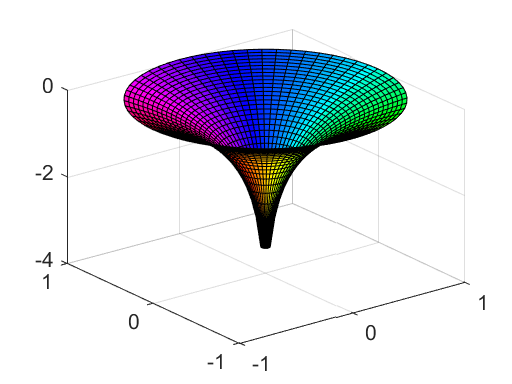

In [10]:
%%matlab
z = cplxgrid(30);
cplxmap(z, log(z))

In [ ]:
# %load ch15/dipole.m
function Phi = dipole (z,z0,S,Beta)
Phi = S*exp(i*Beta)./(2*pi*(z-z0));


In [ ]:
# %load ch15/AnElements.m
% Analytical elements
% Analytical solution of complex potential equation      
%    using MATLAB                     
%
%   $Ekkehard Holzbecher  $Date: 2006/11/28 $
%----------------------------------------------------------input-----------

Q0 = .5;         % baseflow
Q = 0;           % well pumping/recharge rate
A = 0;           % vortex strength 
s = -10;         % dipole strength
beta = 0;        % dipole angle
z0 = 0;          % position of well, vortex or di-pole 

% Mesh
xmin = -5;        % minimum x-position of mesh [m]
xmax = 5;         % maximum x-position of mesh [m]
dx = .21;         % grid spacing in x-direction [m]
ymin = -5;        % minimum y-position of mesh [m]
ymax = 5;         % maximum y-position of mesh[m]
dy = .22;         % grid spacing in y-direction [m]

% Output
gcontf = 50;               % number of filled contours for potential
gcont = 0;                 % number of contours for streamfunction    
gquiv = 0;                 % =1: arrow field
gstream = 1;               % =1: streamline command 

% Start positions (for streamline) 

zstart = xmin + i*(ymin+(ymax-ymin)*[0.1:0.1:1]);
zstart = [zstart xmin-i*0.001];

%--------------------------------------------------------execution---------

[x,y] = meshgrid ([xmin:dx:xmax],[ymin:dy:ymax]);  % mesh
z = x+i*y; 
Phi = -Q0'*z;                                                   % baseflow
if (Q ~= 0) Phi = Phi + (Q/(pi+pi))*log(z-z0); end              % well
if (A ~= 0) Phi = Phi + (A/i*pi)*log(z-z0); end                 % vortex
if (s ~= 0) Phi = Phi + (s/(pi+pi))*exp(i*beta)./(z-z0); end    % dipole

%-----------------------------------------------------------output---------

if gcontf
    colormap(winter);  
    contourf (x,y,real(Phi),gcontf);
end
hold on;
if gcont contour (x,y,imag(Phi),gcont,'w'); end  
[u,v] = gradient (-real(Phi)); 
if gquiv quiver (x,y,u,v,2,'w'); end
if gstream 
    h = streamline (x,y,u,v,real(zstart),imag(zstart));
    set(h,'Color','red');
end

## 15.4 Example: Vortices or Wells Systems

In [ ]:
# %load ch15/wellvortex.m
function wellvortex
% systems of wells or vortices 
%    using MATLAB analytical solutions                   
%
%   $Ekkehard Holzbecher  $Date: 2006/05/30 $
%--------------------------------------------------------------------------
wellvort = 0;                  % wells (1)/ vortices (0)  switch 
mirrorx = 0;                   % symmetry property for x-axis
mirrory = 1;                   % symmetry property for y-axis 
mirror = 0;                    % symmetry / antisymmetry switch
xspace = linspace(-100,100,200); % x-values mesh
yspace = linspace(-100,100,200); % y-values mesh
N = 3;                         % no. of wells / vortices (for random choice)
                               %    for manual input set: N = 0;
zloc = [-20 40] + 1i*[40 60];   % well / vortex positions
s = [5 10];                    % pumping rates / circulation rates 
N0 = 30;                       % no. of filled contours
M0 = 8;                        % no. starting points around each well / vortex
gquiv = 1;                     % arrow field on/off

%------------------------------------- execution --------------------------
xrange = xspace(end) - xspace(1);
yrange = yspace(end) - yspace(1);
[x,y] = meshgrid (xspace,yspace); z = x +1i*y;
if N > 0
    zloc = xspace(1)+xrange*rand(1,N)+1i*(yspace(1)+yrange*rand(1,N));
    s = -10+round(20*rand(1,N));    % strengths unit steps between -10 and 10
else
    N = size(s,2);
end

if mirrorx  
    zloc = [zloc conj(zloc)];
    if mirror 
        s = [s s]; 
    else
        s = [s -s];
    end
end
if mirrory
    zloc = [zloc -real(zloc)+1i*imag(zloc)];
    if mirror 
        s = [s s]; 
    else
        s = [s -s];
    end
end
    
f = Phi(z,zloc,s);
[u,v] = gradient (-real(f));
whitebg([.753,0.753,0.753]);
plot (xspace(1:2),yspace(1)*[1 1],'w'); hold on;
plot (xspace(1:2),yspace(1)*[1 1],'b');
legend ('streamlines','isopotentials')
colormap('jet'); 
xstart = []; ystart = [];
for k = 1:size(s,2)
    for j = 1:M0 xstart = [xstart real(zloc(k))+xrange*cos(2*pi*j/M0)/1000]; 
        ystart = [ystart imag(zloc(k))+yrange*sin(2*pi*j/M0)/1000]; end
end
xspace = linspace (xspace(1),xspace(end),20);
yspace = linspace (yspace(1),yspace(end),20);

%-------------------------------- graphics ------------------------------------
if wellvort
    contourf (x,y,real(f),N0,'b'); hold on;   
    hh = streamline (x,y,u,v,xstart,ystart);
    set (hh,'Color','w');
    hh = streamline (x,y,-u,-v,xstart,ystart);
    set (hh,'Color','w');
    if gquiv             
        [x,y] = meshgrid (xspace,yspace); z = x +i*y; 
        [u,v] = gradient (-real(Phi(z,zloc,s)));
        quiver (x,y,u,v,gquiv,'w'); 
    end
    title ('Well galery: Streamlines & Isopotentials','FontWeight','bold');
else
    contourf (x,y,real(f),N0,'w');
    hh = streamline (x,y,u,v,xstart,ystart);
    set (hh,'Color','b');
    hh = streamline (x,y,-u,-v,xstart,ystart);
    set (hh,'Color','b');
    if gquiv    
        [x,y] = meshgrid (xspace,yspace); z = x +1i*y; 
        [v,u] = gradient (-real(Phi(z,zloc,s))); u = -u;
        quiver (x,y,u,v,gquiv,'w'); 
    end
    title ('Vortices System: Streamlines & Isopotentials','FontWeight','bold');
end
axis off;
hold off; 

function f = Phi (z,zloc,s)
f = 0*z;
for k = 1:size(s,2) 
    f = f + s(k)*log(z-zloc(k))/2/pi; 
end


## 15.5 Example: Thin Objects in Potential Flow

In [ ]:
# %load ch15/fracture.m
% Fracture flow - analytical solution
%
%  E.Holzbecher,    18.4.2011 
%
%-------------------------------------------------- 
perm = 0;           % =1: permeable fracture, =0 impermeable obstacle
velo = 1/10/sqrt(2);% velocity at infinity  
alpha = pi/4;       % baseflow angle
a=2;                % half-length of fracture / obstacle
xmin = -5; xmax = 5; ymin = -5; ymax = 5;
N = 101;

% process & visualize
a = a*a;
xvec = linspace(xmin,xmax,N);
yvec = linspace(ymin,ymax,N);
[x,y] = meshgrid (xvec,yvec);                          % mesh
z = x+i*y;
if perm
    Phi = velo*(z*cos(alpha)-i*sqrt(z.*z-a).*sin(alpha+(x<0)*pi+pi)); % potential
    contourf (x,y,imag(Phi),20);
    hold on; colorbar;
    contour (x,y,real(Phi),20,'w');
    [u,v] = gradient (imag(Phi));           
else
    Phi = velo*(z*cos(alpha)-i*sqrt(z.*z-a).*sin(alpha+(x<0)*pi)); % potential
    contourf (x,y,real(Phi),20);
    hold on; colorbar;
    contour (x,y,imag(Phi),20,'w');
    [u,v] = gradient (real(Phi));
end
qx = ceil(size(x)/9); qy = ceil(size(y)/9);

quiver (x(1:qx:end,1:qy:end),y(1:qx:end,1:qy:end),...
    u(1:qx:end,1:qy:end),v(1:qx:end,1:qy:end),0.5,'w');

## References